In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from pandas.plotting import scatter_matrix
from sklearn import preprocessing, metrics
import category_encoders as ce

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR
import warnings

warnings.filterwarnings("ignore")


In [2]:
# Read files 
df_train = pd.read_csv('TrainAndValid.csv')
df_valid_x = pd.read_csv('Valid.csv')
df_valid_y = pd.DataFrame(pd.read_csv('ValidSolution.csv').SalePrice)
df_test = pd.read_csv('Test.csv')

df_train.set_index('SalesID', inplace=True)
df_valid_x.set_index('SalesID', inplace=True)
df_test.set_index('SalesID', inplace=True)

# df_train contains both train and valid set, so separate two of them
train_index = list(set(df_train.index) - set(df_valid_x.index))
df_train = df_train.loc[train_index]

# Save indices for df_train and df_test - We will use it later to separate two df after encodings
valid_index = df_valid_x.index 
test_index = df_test.index

dfs = [df_train, df_valid_x, df_test]

for df in dfs:
    df['saledate'] = pd.to_datetime(df['saledate'], infer_datetime_format=True)
    df['SaleYear'] = df['saledate'].dt.year 
    df['SaleMonth'] = df['saledate'].dt.month
    df.drop('saledate', axis=1, inplace=True)
    df.drop('fiModelDesc', axis=1, inplace=True)
    

Interesting. We have None or Unspecified in object columns, which should equate to NaN?

In [3]:

# Columns with 'None or Unspecified'
df_train.isin(['None or Unspecified']).any()

# Replace "None or Unspecified" with NaN
for df in dfs:
    df.replace('None or Unspecified', np.nan, inplace=True)

df_train.isin(['None or Unspecified']).any()

# Find out the proportion of missing values in its column
df_train.isna().sum() / len(df_train)

SalePrice                   0.000000
MachineID                   0.000000
ModelID                     0.000000
datasource                  0.000000
auctioneerID                0.050199
YearMade                    0.000000
MachineHoursCurrentMeter    0.644089
UsageBand                   0.826391
fiBaseModel                 0.000000
fiSecondaryDesc             0.342016
fiModelSeries               0.858129
fiModelDescriptor           0.820707
ProductSize                 0.525460
fiProductClassDesc          0.000000
state                       0.000000
ProductGroup                0.000000
ProductGroupDesc            0.000000
Drive_System                0.739829
Enclosure                   0.000815
Forks                       0.965654
Pad_Type                    0.978760
Ride_Control                0.786874
Stick                       0.802720
Transmission                0.600915
Turbocharged                0.990220
Blade_Extension             0.998686
Blade_Width                 0.960272
E

In [4]:
# make lists of column names with object dtype
cat_cols = [i for i in df_train.columns if df_train[i].dtype == 'object']
num_cols = list(set(df_train.columns) - set(cat_cols))

# Find number of unique values in each column with object dtype
display(df_train[cat_cols].nunique())

# Find number of unique values in each column with num dtype
display(df_train[num_cols].nunique())

# Is there any empty entry for num_cols?
display(df_train[num_cols].isna().sum())

UsageBand                     3
fiBaseModel                1950
fiSecondaryDesc             175
fiModelSeries               128
fiModelDescriptor           139
ProductSize                   6
fiProductClassDesc           74
state                        53
ProductGroup                  6
ProductGroupDesc              6
Drive_System                  4
Enclosure                     5
Forks                         1
Pad_Type                      3
Ride_Control                  2
Stick                         2
Transmission                  7
Turbocharged                  1
Blade_Extension               1
Blade_Width                   5
Enclosure_Type                2
Engine_Horsepower             2
Hydraulics                   11
Pushblock                     1
Ripper                        3
Scarifier                     1
Tip_Control                   2
Tire_Size                    16
Coupler                       2
Coupler_System                1
Grouser_Tracks                1
Hydrauli

datasource                       5
SaleYear                        23
YearMade                        72
SalePrice                      899
auctioneerID                    30
ModelID                       5218
MachineID                   341027
SaleMonth                       12
MachineHoursCurrentMeter     15152
dtype: int64

datasource                       0
SaleYear                         0
YearMade                         0
SalePrice                        0
auctioneerID                 20136
ModelID                          0
MachineID                        0
SaleMonth                        0
MachineHoursCurrentMeter    258360
dtype: int64

# EDA
* Try to find distribution of our data
* Will be continued later after some of the values are imputed

SalesID
2701980    1000
1737749    1000
1173071    1000
1737746    1000
1173074    1000
           ... 
6287739    2011
6282508    2011
6287742    2011
2226857    2012
6275685    2013
Name: YearMade, Length: 401125, dtype: int64


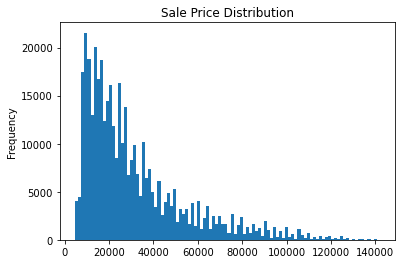

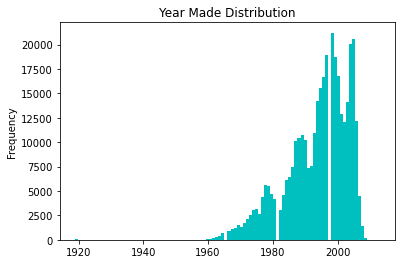

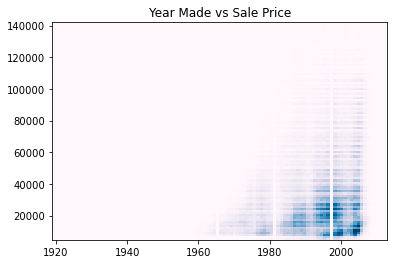

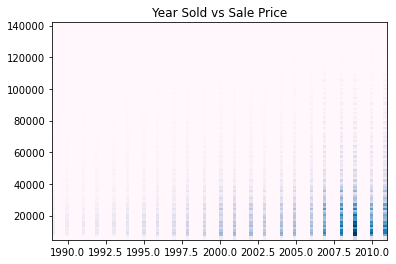

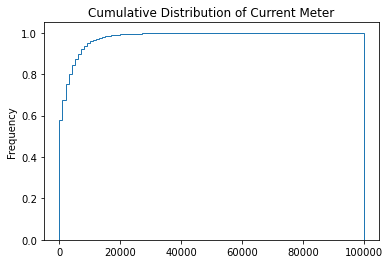

In [5]:
# Check if year made is valid for all 
print(df_train['YearMade'].sort_values())

# Check how many are invalid
(df_train['YearMade'] == 1000).value_counts()

df_train['SalePrice'].plot.hist(bins=100)
plt.title('Sale Price Distribution')
plt.show()

df_train[df_train['YearMade'] != 1000]['YearMade'].plot.hist(bins=100, color='c')
plt.title('Year Made Distribution')
plt.show()

temp_x = df_train[df_train['YearMade'] != 1000].YearMade
temp_y = df_train[df_train['YearMade'] != 1000].SalePrice

plt.hist2d(temp_x, temp_y, bins=100, cmap=plt.cm.PuBu)
plt.title('Year Made vs Sale Price')
plt.show()

plt.hist2d(df_train['SaleYear'], df_train['SalePrice'], bins=100, cmap=plt.cm.PuBu, alpha=1)
plt.title('Year Sold vs Sale Price')
plt.show()

df_train['MachineHoursCurrentMeter'].plot.hist(range=(0,100000), density=True, bins=100, cumulative=True, histtype='step')
plt.title("Cumulative Distribution of Current Meter")
plt.show()

## Strategies?
* Some "YearMade" equal to 1000, which we should consider as nan. Use imputer later.
* Majority of machines have 0 as a current meter. FIll NaN with 0.
* SaleYear - YearMade could be a new feature 

## Let's start with num_cols for filling in missing data

In [6]:
df_train['YearMade'].replace(1000, np.nan, inplace=True)
df_valid_x['YearMade'].replace(1000, np.nan, inplace=True)
df_test['YearMade'].replace(1000, np.nan, inplace=True)

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
df_train['YearMade'] = imputer.fit_transform(pd.DataFrame(df_train.YearMade))
df_valid_x['YearMade'] = imputer.transform(pd.DataFrame(df_valid_x.YearMade))
df_test['YearMade'] = imputer.transform(pd.DataFrame(df_test.YearMade))

for df in dfs:
    # Fill nan current meter as 0 
    df['MachineHoursCurrentMeter'].replace(np.nan, 0, inplace=True)
    # Fill empty auctioneer ID as 1
    df['auctioneerID'].replace(np.nan, -1, inplace=True)
    # Make a new feature - (SaleYear - YearMade)
    df['OwnPeriod'] = df['SaleYear'] - df['YearMade']

# New column added
num_cols.append('OwnPeriod')

In [7]:
display(df_train['MachineHoursCurrentMeter'])


SalesID
2334131    0.0
6291474    0.0
2334132    0.0
6291521    0.0
6291529    0.0
          ... 
6291341    0.0
2334127    0.0
6291384    0.0
2334130    0.0
6291441    0.0
Name: MachineHoursCurrentMeter, Length: 401125, dtype: float64

datasource                  0
SaleYear                    0
YearMade                    0
SalePrice                   0
auctioneerID                0
ModelID                     0
MachineID                   0
SaleMonth                   0
MachineHoursCurrentMeter    0
OwnPeriod                   0
dtype: int64


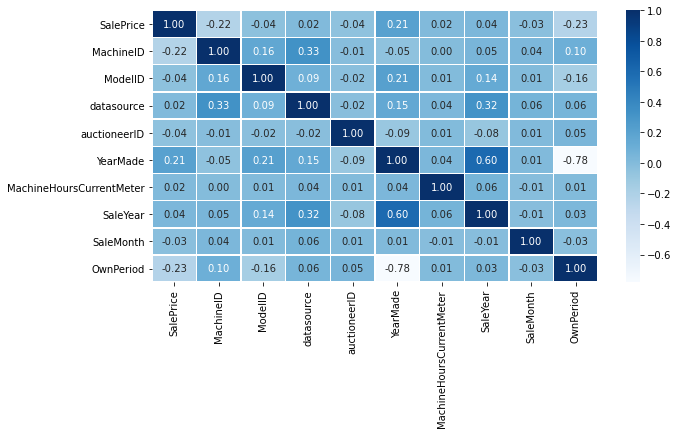

In [8]:
print(df_train[num_cols].isna().sum())

# Show correlation among numerical variables
plt.figure(figsize=(10,5))
sns.heatmap(data = df_train.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

### Now onto categorical features

In [9]:
# Show number of unique values in catgorical columns
display(df_train[cat_cols].nunique())

# Show number of nan values in categorical columns 
display(df_train[cat_cols].isna().sum())

# Let's see if there are any entries in the df_test that are not in df_train

for cat in cat_cols:
    if len(list(set(df_test[cat].unique()) - set(df_train[cat].unique()))) != 0:
        print(cat, set(df_test[cat].unique()) - set(df_train[cat].unique()))
        
# There are some entries in the df_test that are not in df_train. 



UsageBand                     3
fiBaseModel                1950
fiSecondaryDesc             175
fiModelSeries               128
fiModelDescriptor           139
ProductSize                   6
fiProductClassDesc           74
state                        53
ProductGroup                  6
ProductGroupDesc              6
Drive_System                  4
Enclosure                     5
Forks                         1
Pad_Type                      3
Ride_Control                  2
Stick                         2
Transmission                  7
Turbocharged                  1
Blade_Extension               1
Blade_Width                   5
Enclosure_Type                2
Engine_Horsepower             2
Hydraulics                   11
Pushblock                     1
Ripper                        3
Scarifier                     1
Tip_Control                   2
Tire_Size                    16
Coupler                       2
Coupler_System                1
Grouser_Tracks                1
Hydrauli

UsageBand                  331486
fiBaseModel                     0
fiSecondaryDesc            137191
fiModelSeries              344217
fiModelDescriptor          329206
ProductSize                210775
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System               296764
Enclosure                     327
Forks                      387348
Pad_Type                   392605
Ride_Control               315635
Stick                      321991
Transmission               241042
Turbocharged               397202
Blade_Extension            400598
Blade_Width                385189
Enclosure_Type             397829
Engine_Horsepower          375906
Hydraulics                  80565
Pushblock                  395369
Ripper                     380440
Scarifier                  388614
Tip_Control                392113
Tire_Size                  352746
Coupler                    371755
Coupler_System

fiBaseModel {'HL720', 'E30', 'H12', '524', 'PT80', 'SOLAR 250', 'G170', 'ROBOT 165', 'R410', 'JS300', 'EX130', 'ROBEX130', 'HD900', '840-2', 'S650', 'L778', 'ECR145', 'TC75', 'PT100'}
fiSecondaryDesc {' ZTS', '-7A', 'XTD', '5A'}
fiModelSeries {'XR'}
fiModelDescriptor {'HST', 'CL', 'W'}
Backhoe_Mounting {nan}


In [10]:
# Fill all nan with '' for categorical columns
df_train.fillna('',inplace=True)
df_valid_x.fillna('',inplace=True)
df_test.fillna('',inplace=True)

# Any empty columns?
assert(df_train.isna().any().sum() == 0)


## Encoding
* Use Label Encoder for categorical columns with more than 5 unique values
* Use one-hot encoder otherwise



In [11]:
# First create df_train_x
df_train_x = df_train.drop('SalePrice', axis=1)
df_train_y = df_train.SalePrice

# We will encode altogether
df = pd.concat([df_train_x, df_valid_x, df_test], axis=0)


In [12]:
df_train_x

,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiBaseModel,fiSecondaryDesc,fiModelSeries,...,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,SaleYear,SaleMonth,OwnPeriod
SalesID,,,,,,,,,,,,,,,,,,,,,
2334131,1456138,4665,136,8.0,1993.000000,0.0,,450,G,,...,,,,PAT,,,,2008,7,15.000000
6291474,1821164,15154,149,1.0,1996.000000,0.0,,EX60,,LC,...,,Double,,,,,,2011,10,15.000000
2334132,1684175,4640,136,-1.0,1993.000000,0.0,,410,D,,...,,,,,,,,2008,12,15.000000
6291521,1910631,8713,149,1.0,1989.000000,0.0,,EX120,,,...,,Double,,,,,,2011,11,22.000000
6291529,1813932,11585,149,12.0,1993.757403,0.0,,EX100,,-2,...,,Double,,,,,,2011,9,17.242597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6291341,1534873,8724,149,1.0,1989.000000,0.0,,EX60,,,...,,Double,,,,,,2011,9,22.000000
2334127,1272847,8174,136,9.0,1993.757403,0.0,,500,,,...,,,,,,,,2009,5,15.242597
6291384,1829710,11635,149,1.0,1993.757403,0.0,,EX60,URG,,...,,Double,,,,,,2011,10,17.242597


In [13]:
cat_cols_small = [i for i in cat_cols if df[i].nunique() < 6]
cat_cols_large = [i for i in cat_cols if df[i].nunique() >= 6]

# One Hot Encoding for cat_cols_small
encoded = pd.get_dummies(df[cat_cols_small])
df = pd.concat([df, encoded],axis=1)
df.drop(cat_cols_small, axis=1, inplace=True)

# Label Encoding for cat_cols_large
for cat in cat_cols_large:
    enc = LabelEncoder()
    df[cat + '_encoded'] = enc.fit_transform(df[cat].astype(str))
    df.drop(cat, axis=1, inplace=True)


In [14]:
df_train_x = df.loc[train_index]
df_valid_x = df.loc[valid_index]
df_test_x = df.loc[test_index]

In [15]:
#Make sure all values in columns are not object type
[i for i in df_train_x.columns if df_train_x[i].dtype == 'object'] # Should be empty

[]

## Modeling
* XGB regressor
* Random Forest regressor
* Linear Regressor
* SVM

#### But before, we need to define custom scoring function for RMSLE

In [16]:
def rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    n = len(y_true)
    
    log_diff = (np.log(y_true + 1) - np.log(y_pred + 1))**2
    
    return np.sqrt(np.sum(log_diff)/n) 

# Make scorer
score = make_scorer(rmsle)

In [17]:
"""
# XGB regressor 
xgb = XGBRegressor()
params = {'n_estimators':[10,20,50], 'max_depth':[10,20,50], 'learning_rate':[0.01,0.05,0.1]}

reg = RandomizedSearchCV(xgb, params, n_iter=20, cv=5, scoring=score, n_jobs=-1, verbose=True)
reg.fit(df_train_x, df_train_y)
"""

# Takes too long.

"\n# XGB regressor \nxgb = XGBRegressor()\nparams = {'n_estimators':[10,20,50], 'max_depth':[10,20,50], 'learning_rate':[0.01,0.05,0.1]}\n\nreg = RandomizedSearchCV(xgb, params, n_iter=20, cv=5, scoring=score, n_jobs=-1, verbose=True)\nreg.fit(df_train_x, df_train_y)\n"

In [18]:
df_train_x['MachineHoursCurrentMeter']

SalesID
2334131    0.0
6291474    0.0
2334132    0.0
6291521    0.0
6291529    0.0
          ... 
6291341    0.0
2334127    0.0
6291384    0.0
2334130    0.0
6291441    0.0
Name: MachineHoursCurrentMeter, Length: 401125, dtype: float64

In [19]:
# XGB Regressor
xgb = XGBRegressor(n_estimators=50,learning_rate=0.01,n_jobs=-1,random_state=42, verbose=True, scoring=score)
xgb.fit(df_train_x, df_train_y)
pred_val = xgb.predict(df_valid_x)
rmsle(df_valid_y.SalePrice, pred_val)


[00:19:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9652609594793274

In [20]:
# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=50, min_samples_split=3, n_jobs=-1, random_state=42, verbose=True)
rf.fit(df_train_x, df_train_y)
pred_val = rf.predict(df_valid_x)
rmsle(df_valid_y.SalePrice, pred_val)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


0.25811370559191327

#### Random Forest Regressor performs a lot better even without parameter tuning
Let's try Grid Search

In [21]:
"""
# Random Forest Regressor 
rf = RandomForestRegressor()
params = {'n_estimators':[20,50,100], 'max_depth':[10,20,30], 'min_samples_split':[2,3,4]}

reg = RandomizedSearchCV(rf, params, n_iter=10, cv=5, scoring=score, n_jobs=-1, verbose=10)
reg.fit(df_train_x, df_train_y)
"""

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [ ]:
display(reg.best_estimator_)
pred_val = reg.predict(df_valid_x)
rmsle(df_valid_y.SalePrice, pred_val)